# DO NOT RERUN or change yet. still working on this. 

# Entropy from ancestry coefficients (q) and genotype probabilities (gprob)  

Does everything to run entropy and creates slurm files to submit

Goal is 4 chains k=2-X (you decide)

**Create conda env just for entropy**  
`conda create -n entropy`  
`conda activate entropy`  
`conda install popgen-entropy`  

In [1]:
import sys
import ipyparallel as ipp
import os
from os import environ
import gzip
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
import random

In [2]:
root = "/data/gpfs/assoc/denovo/PHHA/"

In [3]:
cd $root

/data/gpfs/assoc/denovo/PHHA


### Create mgpl & pntest files with associated dir 

In [4]:
!mkdir entropy_tf

In [5]:
ent_dir =os.path.join(root,'entropy_tf')
assert ent_dir

In [6]:
cd $ent_dir

/data/gpfs/assoc/denovo/PHHA/entropy_tf


#### copy good_snps.recode.vcf.gz from filtering

In [7]:
!cp ../SNPcall_tf/filtering/good_snps.recode.vcf.gz .

In [8]:
!gunzip 'good_snps.recode.vcf.gz'

In [9]:
vcf = 'good_snps.recode.vcf'
vcf

'good_snps.recode.vcf'

In [10]:
perl_mpgl = '/data/gpfs/assoc/denovo/src/perl_scripts/vcf2mpgl_universal.pl'
perl_mean = '/data/gpfs/assoc/denovo/src/perl_scripts/gl2genest_universal.pl'

In [11]:
!perl $perl_mpgl $vcf

Number of loci: 31652; number of individuals 245


In [12]:
mpgl = 'good_snps.recode.mpgl'

In [13]:
!perl $perl_mean $mpgl mean

### Create ldak files in R

In [14]:
%load_ext rpy2.ipython

In [16]:
%%R
require(readr)
require(MASS)
require(LEA)
require(ggplot2)

source('/data/gpfs/assoc/denovo/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/PHHA/entropy_tf')

R[write to console]: Loading required package: LEA



In [18]:
%%R
#create Pop_ID file 

indv<-read.table("../SNPcall_tf/filtering/good_snps.recode.vcf.gz.012.indv",sep="\t")

Pop_ID <- data.frame(Pop=rep(NA,times=nrow(indv)),
                     ID=NA,
                     All=NA)
for (i in 1:nrow(indv)){
    name_list <-unlist(strsplit(as.character(indv$V1[i]),"_"))
    Pop_ID$Pop[i] <- name_list[2]
    Pop_ID$ID[i] <- name_list[3]
    Pop_ID$All[i] <- as.character(indv$V1[i])
}
print(head(Pop_ID))
print(length(unique(Pop_ID$Pop)))
write.csv(Pop_ID,'Pop_ID.csv',row.names=F)

  Pop ID      All
1  AS 10 PH_AS_10
2  AS 11 PH_AS_11
3  AS 12 PH_AS_12
4  AS  1  PH_AS_1
5  AS  2  PH_AS_2
6  AS  3  PH_AS_3
[1] 26


In [19]:
%%R
g <- read.table("pntest_mean_good_snps.recode.txt", header=F)
dim(g)

[1] 31652   245


In [20]:
%%R
Pop_ID <- read.csv("Pop_ID.csv")
pca_df <- PCA_entropy(t(g))

    PC1     PC2     PC3     PC4     PC5 
0.04176 0.02802 0.02326 0.01952 0.01620 


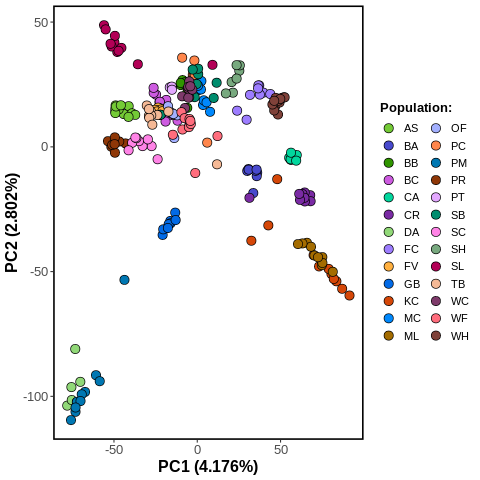

In [23]:
%%R

### check pntest_mean PCA looks okay
pca_df <- cbind(pca_df[,1:10],Pop_ID)


#colors gotten from using hard (force vector) setting: http://medialab.github.io/iwanthue/
col26 <- c("#74ca36","#4849cd","#309500","#cd5be0","#02d69d","#7a2ba4",
           "#91d878","#9d7dff","#ffb040","#026ae6","#d54708","#0088fc",
           "#a46c00","#a3b0ff","#ff864b","#0077b2","#8e3707","#e3a8ff",
           "#008d6e","#ff83e6","#78a97f","#b20056","#f5b996","#7e3a6a",
           "#ff6d7d","#7f4139")
ggplot(data = pca_df, aes(x=PC1,y=PC2,fill=as.character(Pop))) +
  geom_point(pch=21,colour='black',size = 4) + 
  xlab(paste("PC",1," (",0.04176*100,"%)",sep="")) + 
  ylab(paste("PC",2," (",0.02802*100,"%)",sep="")) +
  scale_fill_manual(name = 'Population:',values = col26) +
  theme_bw() + 
  theme(#legend.position = 'none',
        axis.text = element_text(size=13),
        axis.title = element_text(size = 16, colour="black",
                                  face = "bold",vjust = 1),
        panel.border = element_rect(size = 1.5, colour = "black"),
        legend.text = element_text(size = 11),
        legend.title = element_text(size = 13, face = "bold"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())

In [24]:
%%R
#######################################################################################
                                    #### LDA ####
#######################################################################################

k2<-kmeans(pca_df[,1:5],2,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k3<-kmeans(pca_df[,1:5],3,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k4<-kmeans(pca_df[,1:5],4,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k5<-kmeans(pca_df[,1:5],5,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k6<-kmeans(pca_df[,1:5],6,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k7<-kmeans(pca_df[,1:5],7,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k8<-kmeans(pca_df[,1:5],8,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k9<-kmeans(pca_df[,1:5],9,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k10<-kmeans(pca_df[,1:5],10,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k11<-kmeans(pca_df[,1:5],11,iter.max=10,nstart=10,algorithm="Hartigan-Wong")

ldak2<-lda(x=pca_df[,1:5],grouping=k2$cluster,CV=TRUE)
ldak3<-lda(x=pca_df[,1:5],grouping=k3$cluster,CV=TRUE)
ldak4<-lda(x=pca_df[,1:5],grouping=k4$cluster,CV=TRUE)
ldak5<-lda(x=pca_df[,1:5],grouping=k5$cluster,CV=TRUE)
ldak6<-lda(x=pca_df[,1:5],grouping=k6$cluster,CV=TRUE)
ldak7<-lda(x=pca_df[,1:5],grouping=k7$cluster,CV=TRUE)
ldak8<-lda(x=pca_df[,1:5],grouping=k8$cluster,CV=TRUE)
ldak9<-lda(x=pca_df[,1:5],grouping=k9$cluster,CV=TRUE)
ldak10<-lda(x=pca_df[,1:5],grouping=k10$cluster,CV=TRUE)
ldak11<-lda(x=pca_df[,1:5],grouping=k11$cluster,CV=TRUE)

write.table(round(ldak2$posterior,5),file="ldak2.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak3$posterior,5),file="ldak3.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak4$posterior,5),file="ldak4.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak5$posterior,5),file="ldak5.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak6$posterior,5),file="ldak6.txt",quote=F,row.names=F,col.names=F)                                      
write.table(round(ldak7$posterior,5),file="ldak7.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak8$posterior,5),file="ldak8.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak9$posterior,5),file="ldak9.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak10$posterior,5),file="ldak10.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak11$posterior,5),file="ldak11.txt",quote=F,row.names=F,col.names=F)


In [25]:
%%R
######### create entropy header ####

Pop_ID_list <- paste(Pop_ID$Pop,Pop_ID$ID,sep='_')

Header <- data.frame(dims = NA,Pop_ID_list)

dim(g)

df <- t(Header)
dims <- paste(dim(g)[2],dim(g)[1],sep = " ")

df[1,1] <- dims

write.table(df,'entropy_header.txt',sep = " ",na ="",
            quote = FALSE,row.names = FALSE,col.names = FALSE)

In [26]:
!head entropy_header.txt

245 31652                                                                                                                                                                                                                                                    
AS_10 AS_11 AS_12 AS_1 AS_2 AS_3 AS_4 AS_5 AS_6 AS_7 AS_8 AS_9 BA_10 BA_1 BA_2 BA_3 BA_4 BA_5 BA_7 BA_9 BB_10 BB_1 BB_2 BB_3 BB_4 BB_5 BB_6 BB_7 BB_8 BB_9 BC_10 BC_11 BC_1 BC_2 BC_3 BC_4 BC_5 BC_6 BC_7 BC_8 BC_9 CA_10 CA_12 CA_1 CA_2 CA_3 CA_4 CA_6 CA_7 CA_8 CR_10 CR_11 CR_12 CR_1 CR_2 CR_3 CR_4 CR_5 CR_6 CR_7 CR_8 CR_9 DA_2 DA_5 DA_6 DA_7 DA_8 FC_10 FC_11 FC_12 FC_1 FC_2 FC_4 FC_6 FC_8 FC_9 FV_10 FV_11 FV_12 FV_1 FV_2 FV_4 FV_5 FV_6 FV_7 FV_8 FV_9 GB_10 GB_11 GB_12 GB_1 GB_5 GB_6 GB_8 GB_9 KC_10 KC_11 KC_1 KC_2 KC_3 KC_4 KC_5 KC_6 KC_7 KC_8 KC_9 MC_10 MC_11 MC_12 MC_5 MC_6 MC_7 MC_8 MC_9 ML_10 ML_11 ML_12 ML_1 ML_2 ML_3 ML_4 ML_5 ML_6 ML_8 OF_10 OF_11 OF_12 OF_3 OF_4 OF_5 OF_6 OF_7 PC_10 PC_11 PC_12 PC_1 PC_2 PC_3 PC_4 PC_5 PC_6 PC_7 P

In [27]:
!cat entropy_header.txt good_snps.recode.mpgl > entropy.mpgl

In [28]:
cd $ent_dir

/data/gpfs/assoc/denovo/PHHA/entropy_tf


In [29]:
!mkdir shdir

In [30]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '8-00:00:00' #time limit 4
cpus = 4 #to prevent hammering one node
mem_cpu = 8000
email = 'tfaske@nevada.unr.edu'

#entropy settings
l = 60000
b = 10000
num_k = [2,3,4,5,6,7,8,9]
chains = 4

**Note:** Random seed needs to be created for each chain. Most programs use the clock as the seed, which is typically fine but since the clock on the HPC only goes to minutes and we are running everything at the same time, all the seeds are the same. Giving you the same exact seed. 

In [31]:
def write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains):
    for k in num_k:
        for c in range(1,chains+1):
            jobname = 'k%d_c%d' % (k,c)
            seed = random.randint(1000,9999) #default is clock so messes up if submitted same time 
            with open("shdir/run_entropy_%s.sh" % (jobname), "w") as o:
                o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ent_%s
#SBATCH --output output_%s.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,jobname,jobname,email))
        
                o.write("entropy -i ../entropy.mpgl -o ../entropy_%s.hdf5 -r %d -n 2 -l %d -b %d -t 10 -s 50 -e .01 -k %d -q ../ldak%d.txt -m 1 -w 0"
                        % (jobname,seed,l,b,k,k))
    

In [32]:
write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains)

In [33]:
entShells = !find $ent_dir -name 'run_entropy*.sh'
entShells = entShells.sort()
entShells

['/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k2_c1.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k2_c2.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k2_c3.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k2_c4.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k3_c1.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k3_c2.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k3_c3.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k3_c4.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k4_c1.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k4_c2.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k4_c3.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k4_c4.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k5_c1.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_entropy_k5_c2.sh',
 '/dat

In [34]:
def write_sbatch_entShells(entShells):
         with open("shdir/sbatch_entropy.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in entShells:
                o.write("""sbatch %s\n""" % (sh))

In [35]:
write_sbatch_entShells(entShells)

# Run all entropy*sh
    cd /data/gpfs/home/tfaske/d/milkweed/entropy/shdir
    source activate entropy
    bash sbatch_entropy.sh

# Use estpost to get DIC, q, and gprob

In [47]:
np.set_printoptions(precision=8) # increases float print option
pd.set_option("precision", 8)

In [48]:
cd $ent_dir

/data/gpfs/assoc/denovo/PHHA/entropy_tf


In [49]:
hdf5_files = !find . -name '*hdf5'
hdf5_files = hdf5_files.sort()
hdf5_files

['./entropy_k2_c1.hdf5',
 './entropy_k2_c2.hdf5',
 './entropy_k2_c3.hdf5',
 './entropy_k2_c4.hdf5',
 './entropy_k3_c1.hdf5',
 './entropy_k3_c2.hdf5',
 './entropy_k3_c3.hdf5',
 './entropy_k3_c4.hdf5',
 './entropy_k4_c1.hdf5',
 './entropy_k4_c2.hdf5',
 './entropy_k4_c3.hdf5',
 './entropy_k4_c4.hdf5',
 './entropy_k5_c1.hdf5',
 './entropy_k5_c2.hdf5',
 './entropy_k5_c3.hdf5',
 './entropy_k5_c4.hdf5',
 './entropy_k6_c1.hdf5',
 './entropy_k6_c2.hdf5',
 './entropy_k6_c3.hdf5',
 './entropy_k6_c4.hdf5',
 './entropy_k7_c1.hdf5',
 './entropy_k7_c2.hdf5',
 './entropy_k7_c3.hdf5',
 './entropy_k7_c4.hdf5',
 './entropy_k8_c1.hdf5',
 './entropy_k8_c2.hdf5',
 './entropy_k8_c3.hdf5',
 './entropy_k8_c4.hdf5',
 './entropy_k9_c1.hdf5',
 './entropy_k9_c2.hdf5',
 './entropy_k9_c3.hdf5',
 './entropy_k9_c4.hdf5']

In [50]:
estpost = '/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy'

In [51]:
#make DIC
for i in range(0,len(hdf5_files)):
    f = hdf5_files[i]
    k = f.split('_')[1] #set this 
    c = f.split('_')[2].split('.hdf5')[0]
    #print(k,c)
    dic = "DIC_%s_%s.txt" % (k,c)
    !$estpost $f -s 3 -p deviance > $dic

In [52]:
dic_files = !find . -name 'DIC*'
dic_files

['./DIC_k2_c4.txt',
 './DIC_k7_c2.txt',
 './DIC_k2_c1.txt',
 './DIC_k6_c1.txt',
 './DIC_k3_c2.txt',
 './DIC_k4_c4.txt',
 './DIC_k4_c2.txt',
 './DIC_k7_c1.txt',
 './DIC_k7_c4.txt',
 './DIC_k5_c2.txt',
 './DIC_k6_c2.txt',
 './DIC_k4_c3.txt',
 './DIC_k7_c3.txt',
 './DIC_k3_c1.txt',
 './DIC_k2_c2.txt',
 './DIC_k5_c4.txt',
 './DIC_k8_c4.txt',
 './DIC_k6_c3.txt',
 './DIC_k8_c3.txt',
 './DIC_k8_c1.txt',
 './DIC_k4_c1.txt',
 './DIC_k2_c3.txt',
 './DIC_k8_c2.txt',
 './DIC_k9_c3.txt',
 './DIC_k9_c2.txt',
 './DIC_k6_c4.txt',
 './DIC_k3_c4.txt',
 './DIC_k9_c1.txt',
 './DIC_k5_c1.txt',
 './DIC_k3_c3.txt',
 './DIC_k5_c3.txt',
 './DIC_k9_c4.txt']

In [53]:
for d in dic_files:
    !cat $d
    print('\n')

file = ./entropy_k2_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 11458252.40
Effective number of parameters: 9305543.01
Model DIC: 20763795.41


file = ./entropy_k7_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 10407941.47
Effective number of parameters: 23026081.36
Model DIC: 33434022.83


file = ./entropy_k2_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 11458907.23
Effective number of parameters: 8617003.97
Model DIC: 20075911.20


file = ./entropy_k6_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 10544115.67
Effective number of parameters: 13100007.87
Model DIC: 23644123.55


file = ./entropy_k3_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 11106780.05
Effective number of parameters: 365354740.38
Model DIC: 376461520.43


file = ./entropy_k4_c4.hdf5
parameter dimensions for deviance: sa

In [54]:
dic_list = []
for d in dic_files:
    k = d.split('_k')[1].split('_')[0] #set this 
    c = d.split('_c')[1].split('.txt')[0]
    #print(k,c)
    
    dic = !grep 'DIC' $d
    dic = float(re.search('(\d+.\d+)',str(dic)).group(0))
    #print(dic)
    
    dic_list.append([k,dic,c])
dic_df = pd.DataFrame(dic_list,columns=['k','DIC','chain'])
dic_df.head()

,k,DIC,chain
0,2,2.07637954e+07,4
1,7,3.34340228e+07,2
2,2,2.00759112e+07,1
3,6,2.36441236e+07,1
4,3,3.76461520e+08,2


In [55]:
dic_df.to_csv('dic_list.csv')

In [56]:
dic_sum = dic_df.groupby('k').describe().DIC

In [57]:
dic_sum.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
2,4.0,2.08533947e+07,6.99354816e+05,20075911.20,2.05918244e+07,20780706.150,2.10422765e+07,2.17762553e+07
5,4.0,2.41949283e+07,6.71287867e+05,23392342.49,2.37649566e+07,24317473.095,2.47474447e+07,2.47524244e+07
6,4.0,2.43820018e+07,1.52578080e+06,22587791.68,2.33800406e+07,24603319.150,2.56052804e+07,2.57335772e+07
4,4.0,2.48249494e+07,8.70241756e+05,23915147.70,2.41750304e+07,24839185.470,2.54891044e+07,2.57062789e+07
8,4.0,2.48792990e+07,7.63567481e+05,24362306.18,2.44784700e+07,24570836.280,2.49716652e+07,2.60132171e+07
7,4.0,2.68815199e+07,4.54693933e+06,23273326.17,2.41767803e+07,25409365.390,2.81141050e+07,3.34340228e+07
9,4.0,2.81894403e+07,2.61405582e+06,24632105.14,2.72367172e+07,28669292.660,2.96220157e+07,3.07870706e+07
3,4.0,3.15783011e+08,4.26880649e+07,279505722.19,2.90624623e+08,303582400.315,3.28740788e+08,3.76461520e+08


In [58]:
dic_sum.to_csv('dic_sum.csv')

### Get gprob and q for each k, and mcmc metrics

In [59]:
# ancestry coeffecients 
!$estpost *k2*.hdf5 -p q -s 0 -o q2.txt

!$estpost *k3*.hdf5 -p q -s 0 -o q3.txt

!$estpost *k4*.hdf5 -p q -s 0 -o q4.txt

!$estpost *k5*.hdf5 -p q -s 0 -o q5.txt

!$estpost *k6*.hdf5 -p q -s 0 -o q6.txt

!$estpost *k7*.hdf5 -p q -s 0 -o q7.txt

!$estpost *k8*.hdf5 -p q -s 0 -o q8.txt

!$estpost *k9*.hdf5 -p q -s 0 -o q9.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 245, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 245, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 245, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 245, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 245, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entrop

In [60]:
#MCMC diagnostics
!$estpost *k2*.hdf5 -p q -s 4 -o MCMC_k2.txt

!$estpost *k3*.hdf5 -p q -s 4 -o MCMC_k3.txt

!$estpost *k4*.hdf5 -p q -s 4 -o MCMC_k4.txt

!$estpost *k5*.hdf5 -p q -s 4 -o MCMC_k5.txt

!$estpost *k6*.hdf5 -p q -s 4 -o MCMC_k6.txt

!$estpost *k7*.hdf5 -p q -s 4 -o MCMC_k7.txt

!$estpost *k8*.hdf5 -p q -s 4 -o MCMC_k8.txt

!$estpost *k9*.hdf5 -p q -s 4 -o MCMC_k9.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 245, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 245, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 245, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 245, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 245, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entrop

### make slurm script to make gprob file

    use all k and chains to make gprob

In [61]:
cd $ent_dir

/data/gpfs/assoc/denovo/PHHA/entropy_tf


In [73]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 6000
email = 'tfaske@nevada.unr.edu'

### select k 
num_k = [2,3,4,6,7,8,9]

In [74]:
def write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k):
    for k in num_k:
        with open("shdir/run_gprob_k%d.sh" % (k), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprob_k%d
#SBATCH --output output_gprob_k%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,k,k,email))
        
            o.write("%s ../*k%d*.hdf5 -p gprob -s 0 -o ../gprob%d.txt" % (estpost,k,k))

In [75]:
write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k)

In [76]:
gprobShells = !find $ent_dir -name 'run_gprob*.sh'
gprobShells = gprobShells.sort()
gprobShells

['/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_gprobAll.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_gprob_k10.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_gprob_k11.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_gprob_k2.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_gprob_k3.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_gprob_k4.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_gprob_k6.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_gprob_k7.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_gprob_k8.sh',
 '/data/gpfs/assoc/denovo/PHHA/entropy_tf/shdir/run_gprob_k9.sh']

In [77]:
def write_sbatch_gprobShells(gprobShells):
    with open("shdir/sbatch_gprob.sh", "w") as o:
        o.write("""#!/usr/bin/env bash \n""")
        for sh in gprobShells:
            o.write("""sbatch %s\n""" % (sh))

In [78]:
write_sbatch_gprobShells(gprobShells)

### gprob all 

select only the ks you want. Will not work on ~7 ks with all the chains. It dies. 

For PHHA, ignore k=3 and do rest

In [81]:
hdf5_files = []
num_k = [2,4,6,7,8,9]
num_c = 4
for k in num_k:
    for c in range(1,num_c+1):
        f = '../entropy_k' + str(k) + '_c' + str(c) + '.hdf5'
        hdf5_files.append(f)
hdf5_files

['../entropy_k2_c1.hdf5',
 '../entropy_k2_c2.hdf5',
 '../entropy_k2_c3.hdf5',
 '../entropy_k2_c4.hdf5',
 '../entropy_k4_c1.hdf5',
 '../entropy_k4_c2.hdf5',
 '../entropy_k4_c3.hdf5',
 '../entropy_k4_c4.hdf5',
 '../entropy_k6_c1.hdf5',
 '../entropy_k6_c2.hdf5',
 '../entropy_k6_c3.hdf5',
 '../entropy_k6_c4.hdf5',
 '../entropy_k7_c1.hdf5',
 '../entropy_k7_c2.hdf5',
 '../entropy_k7_c3.hdf5',
 '../entropy_k7_c4.hdf5',
 '../entropy_k8_c1.hdf5',
 '../entropy_k8_c2.hdf5',
 '../entropy_k8_c3.hdf5',
 '../entropy_k8_c4.hdf5',
 '../entropy_k9_c1.hdf5',
 '../entropy_k9_c2.hdf5',
 '../entropy_k9_c3.hdf5',
 '../entropy_k9_c4.hdf5']

In [82]:
gprob_cmd = estpost + ' ' + ' '.join(hdf5_files) + ' -p gprob -s 0 -o ../gprobAll.txt'
gprob_cmd

'/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy ../entropy_k2_c1.hdf5 ../entropy_k2_c2.hdf5 ../entropy_k2_c3.hdf5 ../entropy_k2_c4.hdf5 ../entropy_k4_c1.hdf5 ../entropy_k4_c2.hdf5 ../entropy_k4_c3.hdf5 ../entropy_k4_c4.hdf5 ../entropy_k6_c1.hdf5 ../entropy_k6_c2.hdf5 ../entropy_k6_c3.hdf5 ../entropy_k6_c4.hdf5 ../entropy_k7_c1.hdf5 ../entropy_k7_c2.hdf5 ../entropy_k7_c3.hdf5 ../entropy_k7_c4.hdf5 ../entropy_k8_c1.hdf5 ../entropy_k8_c2.hdf5 ../entropy_k8_c3.hdf5 ../entropy_k8_c4.hdf5 ../entropy_k9_c1.hdf5 ../entropy_k9_c2.hdf5 ../entropy_k9_c3.hdf5 ../entropy_k9_c4.hdf5 -p gprob -s 0 -o ../gprobAll.txt'

In [83]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 1 #to prevent hammering one node
mem_cpu = 100000
email = 'tfaske@nevada.unr.edu'

In [84]:
def write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd):
        with open("shdir/run_gprobAll.sh", "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprobAll
#SBATCH --output output_gprobAll.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

%s""" % (account,partition,time,cpus,mem_cpu,email,gprob_cmd))

In [85]:
write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd)

## Run gprob sh 

    cd /data/gpfs/assoc/denovo/PHHA/entropy
    source activate entropy
    sbatch run_gprob.sh